In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt

from arch import arch_model

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


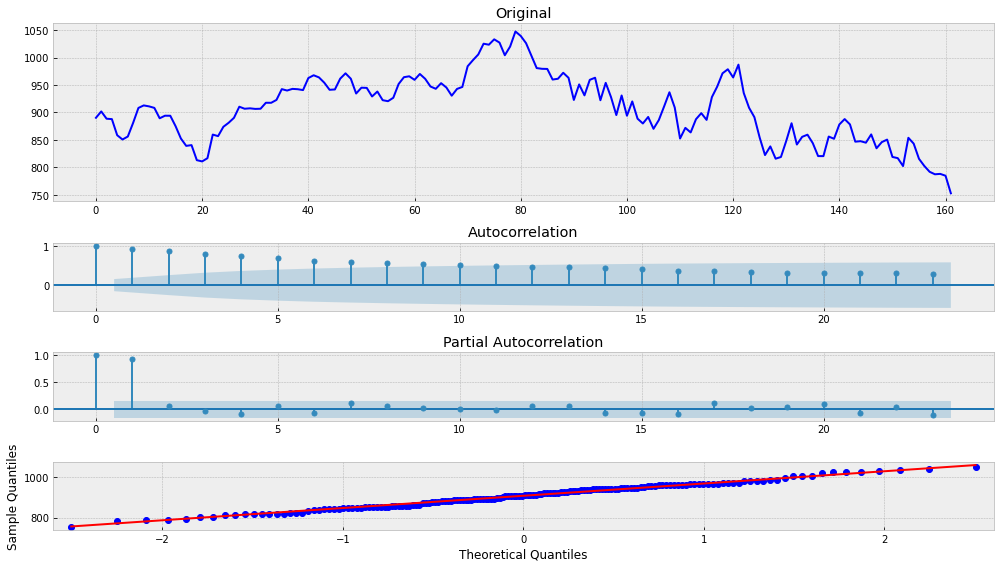

In [6]:
series = dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']
tsplot(series)

In [7]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [8]:
aic, order, mdl = _get_best_model(series)

aic: 1416.27670 | order: (2, 2, 3)


Results of Dickey-Fuller Test:
Test Statistic                -1.184571e+01
p-value                        7.408147e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


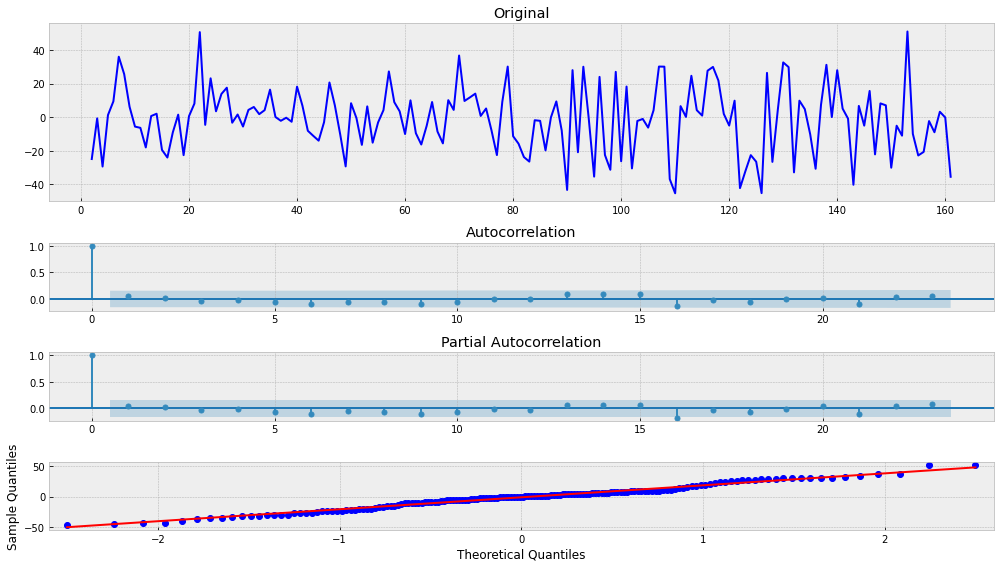

In [9]:
tsplot(mdl.resid)

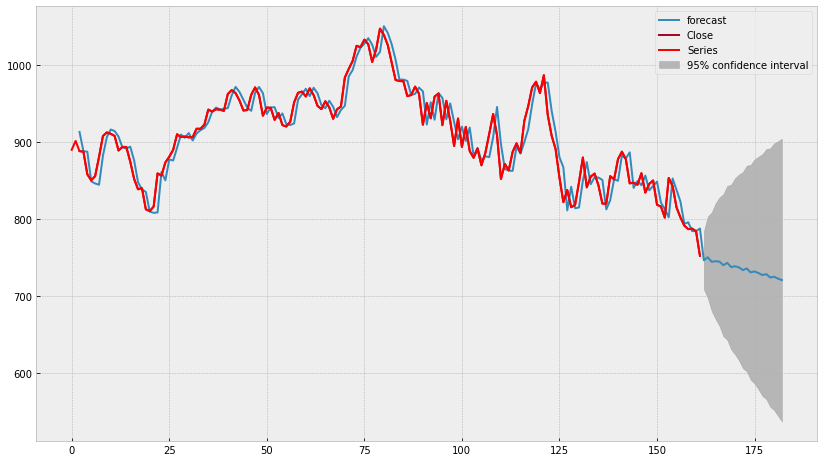

In [10]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(2, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [11]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]

In [12]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     78,   Neg. LLF: 2940.2798502183014
Iteration:     10,   Func. Count:    159,   Neg. LLF: 575.902549863791
Iteration:     15,   Func. Count:    227,   Neg. LLF: 2765.3554290617585
Iteration:     20,   Func. Count:    290,   Neg. LLF: -312.90416443419207
Iteration:     25,   Func. Count:    349,   Neg. LLF: -313.3417431624103
Iteration:     30,   Func. Count:    404,   Neg. LLF: -313.9102601652324
Iteration:     35,   Func. Count:    459,   Neg. LLF: -314.2002333612959
Iteration:     40,   Func. Count:    514,   Neg. LLF: -301.4038317148827
Iteration:     45,   Func. Count:    574,   Neg. LLF: -314.2894356673737
Optimization terminated successfully    (Exit mode 0)
            Current function value: -314.2894356673737
            Iterations: 48
            Function evaluations: 574
            Gradient evaluations: 45
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-

Results of Dickey-Fuller Test:
Test Statistic                  -3.433413
p-value                          0.009871
#Lags Used                      14.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


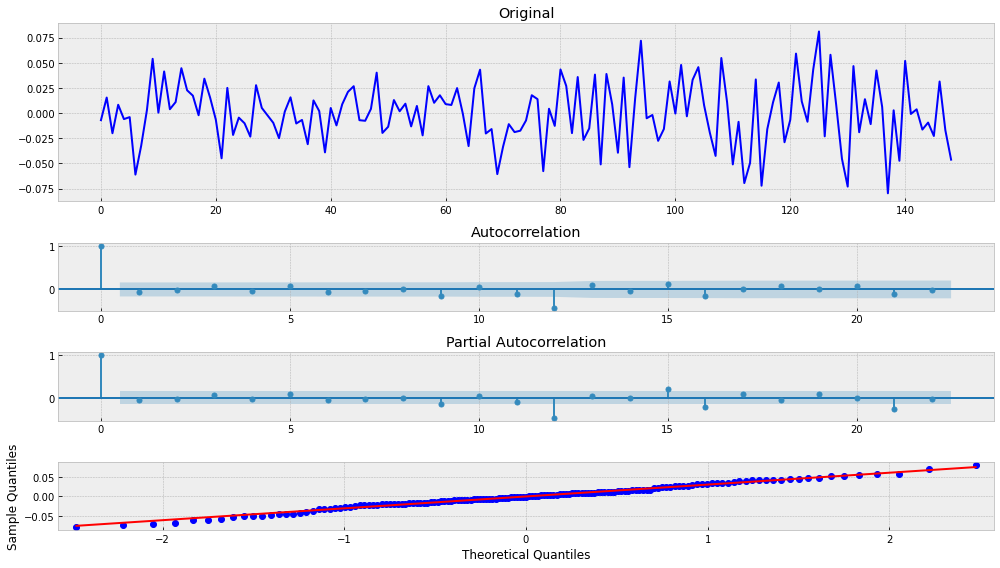

In [13]:
tsplot(res.resid)

#### Прогноз линейной регрессией

In [14]:
series = dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [15]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    test_index = int(len(data)*(1-test_size))
    
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

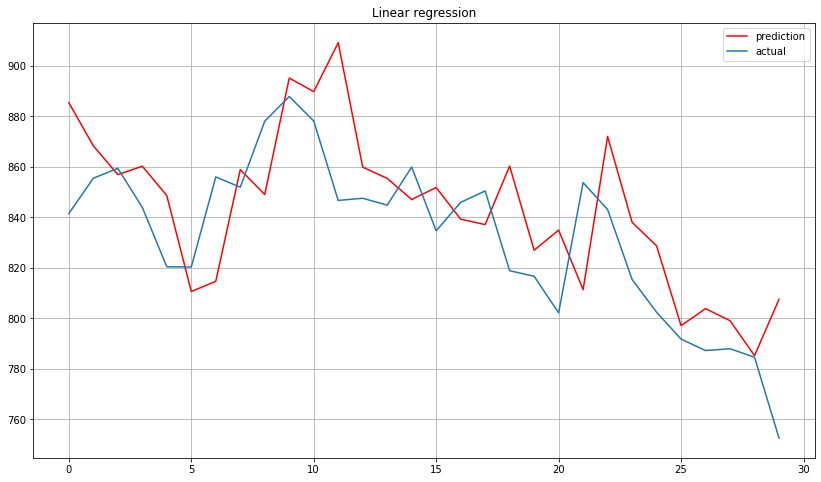

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);